In [41]:
# import libraries
import pandas as pd
import quandl, math,datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [42]:
# Sign up to quandl.com to get an api_key
df = quandl.get('WIKI/GOOGL', api_key='qTJxd5E1ES4AddsKB9JF')
df.head()


,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [43]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

In [44]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume' ]]

In [45]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [46]:
df.dtypes

Adj. Open      float64
Adj. High      float64
Adj. Low       float64
Adj. Close     float64
Adj. Volume    float64
dtype: object

In [47]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0

In [48]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT
Date,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,8.441017
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,8.537313
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,4.062357
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,7.753210
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,3.966115


In [50]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0


In [51]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,8.441017,0.324968
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,8.537313,7.227007
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,4.062357,-1.227880
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,7.753210,-5.726357
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,3.966115,1.183658


In [52]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]


In [53]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0
2004-08-20,54.322689,8.537313,7.227007,22834300.0
2004-08-23,54.869377,4.062357,-1.227880,18256100.0
2004-08-24,52.597363,7.753210,-5.726357,15247300.0
2004-08-25,53.164113,3.966115,1.183658,9188600.0


In [54]:
forecast_col = 'Adj. Close'

In [55]:
# Fill missing data with an arbitrary value to ensure there are all numerical values
# It will be treated as an outlier instead of dropping the column
df.fillna(-99999, inplace=True)

In [56]:
# math.ceil takes a number and returns the nearest whole number
# 0.1 is using 10 days data to make today's prediction
forecast_out = int(math.ceil(0.01*len(df)))
#forecast_out = math.ceil(34)
#len(df)

In [57]:
# Create the label column
df['label'] = df[forecast_col].shift(-forecast_out)

In [59]:
#df.dropna(inplace=True)

In [60]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,69.078238
2004-08-20,54.322689,8.537313,7.227007,22834300.0,67.839414
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,3.966115,1.183658,9188600.0,71.219849


In [61]:
#import numpy
#import sklearn's preprocessing module, svm, cross_validate & linearRegression module.

In [62]:
# Create our X(features) and y(label)
X = np.array(df.drop(['label'],1))

In [63]:
#y = np.array(df['label'])

In [64]:
# Scaling X
X = preprocessing.scale(X)

In [65]:
X = X[:-forecast_out]
X_lately = X[-forecast_out:] # What we would predict against

In [66]:
df.dropna(inplace=True)

In [67]:
y = np.array(df['label'])

In [68]:
print(len(X), len(y))

3389 3389


In [69]:
# Create our train and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [70]:
# Assign Classifier to a variable clf
#clf = LinearRegression(n_jobs=2)

In [73]:
# Fit the train feature and label
#clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [74]:
#Pickling & Scaling
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)

In [75]:
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

In [76]:
print(clf)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


In [77]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [78]:
# test the train on test data
accuracy = clf.score(X_test,y_test)

In [79]:
print(accuracy)

0.9781951243023469


In [80]:
# Days in advance
print(forecast_out)

35


In [81]:
# Training using svm
clf_svm = svm.SVR()

In [82]:
clf_svm.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [83]:
accuracy_svm = clf_svm.score(X_test,y_test)
print(accuracy_svm)

0.8084993647374368


In [84]:
# Predict based on the X data
forecast_set = clf.predict(X_lately)

In [85]:
print(forecast_set, accuracy, forecast_out)

[1077.40982518 1091.70186067 1105.35793299 1099.91203349 1093.4461708
 1091.19696068 1089.76188369 1086.15722015 1080.31556731 1075.91101625
 1073.91828637 1093.18951071 1111.63469748 1116.35761431 1131.10240592
 1135.24752463 1133.37507126 1131.196082   1132.84361673 1151.12827134
 1150.31670618 1159.81205769 1156.43382627 1164.67272104 1185.00987653
 1197.56269028 1191.42290037 1203.45866761 1208.24762172 1207.66107578
 1198.44790391 1203.29273754 1202.25857351 1137.65118078 1083.41820135] 0.9781951243023469 35


In [86]:
df['Forecast'] = np.nan

In [87]:
last_date = df.iloc[-1].name
print(last_date)

2018-02-05 00:00:00


In [88]:
last_unix = last_date.timestamp()
print(last_unix)

1517788800.0


In [89]:
one_day = 86400 # Seconds in a day

In [90]:
next_unix = last_unix + one_day
print(next_unix)

1517875200.0


In [91]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [92]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,69.078238,NaN
2004-08-20,54.322689,8.537313,7.227007,22834300.0,67.839414,NaN
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,68.912727,NaN
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,70.668146,NaN
2004-08-25,53.164113,3.966115,1.183658,9188600.0,71.219849,NaN


In [93]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-03-08 01:00:00,NaN,NaN,NaN,NaN,NaN,1198.447904
2018-03-09 01:00:00,NaN,NaN,NaN,NaN,NaN,1203.292738
2018-03-10 01:00:00,NaN,NaN,NaN,NaN,NaN,1202.258574
2018-03-11 01:00:00,NaN,NaN,NaN,NaN,NaN,1137.651181
2018-03-12 01:00:00,NaN,NaN,NaN,NaN,NaN,1083.418201


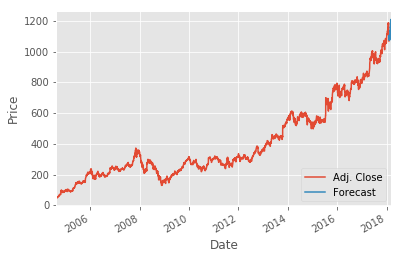

In [94]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()